# Viability Check

Le but de ce document est d'utiliser une base de donnée pour en ressortir les informations utiles et essayer d'analyser tout cela.

Tout dans le code n'est donc pas pertinant puisqu'il y a des analyse qui n'aboutisse à rien.

Pour pouvoir faire correctement fonctionner ce jupyter Notebook il faut :
- un ficher nomé passages_pour_analyse.csv contenant au moins les collones suivantes :
    - pas_id
    - pas_id_mariage
    - pas_date_passage
    - pas_id_tour
    - pas_heuredebut
    - pas_heurefin
    - alatitude
    - alongitude
- que ce ficher ai toute les tournée des camions ordonnée selon les passage de livraison. (autrement il y a un marqueur TODO qui met a disposition un morceau de code qui est en mesure de le faire.)
- un server local de TuxyRoad fonctionnel pour lequel on peut faire des appel au géocodeur (sur le port 5000)
- un server local de OSRM fonctionnel pour lequel on fait des appels de routing. (sur le port 5001)
- du temps car la base de donnée est grande et que le calcul de tout le routing ... est long (il faut compter environ 4-6h avant d'obtenir le ficher contenant la DB avec les informations manquantes) Et au moins 3h de plus pour le reste de l'analyse qui par endroit est très time consuming. (le code n'a pas été optimiser pour cela il s'agissais vraiment de faire tourné cela pendant la nuit pour ne pas perdre de temps.)



In [56]:
import pandas as pd
import os.path
import requests as re
import json
import datetime as dtime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import collections

from datetime import datetime


def iso_to_sec(iso):
    """change a given time from iso format in to seconds"""
    splited_iso = iso.split(':')
    return int(float(splited_iso[0]) * 3600 + float(splited_iso[1]) * 60 + float(splited_iso[2]))


def sec_to_iso(sec):
    """change a given time in seconde to an iso formated time"""
    return str(dtime.timedelta(seconds=sec))


def diff_arival_dep(dep, arr):
    """calculate the differenciation between 2 iso formated time arrival - departur"""
    return iso_to_sec(arr) - iso_to_sec(dep)


def iso_compare(iso1, iso2):
    """compare if the given first iso time is strictly bigger than the second one"""
    return iso_to_sec(iso1) > iso_to_sec(iso2)


def str_to_datetime(date_str):
    """convert a given string formated this way %Y-%m-%d to a datatime object"""
    return datetime.strptime(date_str,"%Y-%m-%d")


def is_dense(dte):
    """Check if the date is in a dense period or not"""
    # période dense : Juil-Aou
    debut_per_dense = str_to_datetime('2018-07-01')
    fin_per_dense = str_to_datetime('2018-08-31')
    return debut_per_dense <= dte and dte <= fin_per_dense


def is_creuse(dte):
    """Check if the date is in a creuse period or not"""
    # période creuse : Jan-Nov-Dec
    d_j = str_to_datetime('2018-01-01')
    f_j = str_to_datetime('2018-01-31')
    d_p_c = str_to_datetime('2018-11-01')
    f_p_c = str_to_datetime('2018-12-31')
    return (d_j <= dte and dte <= f_j) or (d_p_c <= dte and dte <= f_p_c)


def is_mid_plus(dte):
    """Check if the date is in a medium + period or not"""
    # période moyen plus : Avr-Mai-Juin-Sept
    d_p_m_p = str_to_datetime('2018-04-01')
    f_p_m_p = str_to_datetime('2018-06-30')
    d_s = str_to_datetime('2018-09-01')
    f_s = str_to_datetime('2018-09-30')
    return (d_p_m_p <= dte and dte <= f_p_m_p) or (d_s <= dte and dte <= f_s)


def is_mid_min(dte):
    """Check if the date is in a medium - period or not"""
    # période moyen moins : Fev-Mars-Oct
    d_p_m_m = str_to_datetime('2018-02-01')
    f_p_m_m = str_to_datetime('2018-03-31')
    d_o = str_to_datetime('2018-10-01')
    f_o = str_to_datetime('2018-10-31')
    return (d_p_m_m <= dte and dte <= f_p_m_m) or (d_o <= dte and dte <= f_o)


def is_less_than_thresh(t_ref,t_comp):
    """Check that t_comp is effectively less than the t_ref with the congestion level given by max_threshold"""
    max_threshold = 100 # c'est des %
    return (t_comp < (t_ref + max_threshold * t_ref/100))

    
def dist_haversin(lon1,lat1,lon2,lat2):
    """given 2 points in WGS84 calculate the fly distance between them"""
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - math.cos((lat2 - lat1) * p)/2 + math.cos(lat1 * p) * math.cos(lat2 * p) * (1 - math.cos((lon2 - lon1) * p)) / 2
    return 12742 * math.asin(math.sqrt(a)) * 1000

In [57]:
file = "passages_pour_analyse.csv"
server_url = "http://127.0.0.1:5000/geocode"
osrm_url = "http://127.0.0.1:5001/route/v1/driving/"
header = {
    'User-Agent': 'Dumb Generator',
    'Content-Type': 'application/json'
}

df = pd.read_csv(file, sep=';')
del_col = ['ctitre', 'cnom', 'cprenom', 'arue', 'arue1', 'acanton']
df.drop(del_col, inplace=True, axis=1)
df = df[df.pas_id.notnull()]
df = df[df.pas_date_passage.notnull()]
df = df[df.pas_id_tour.notnull()]
df = df[df.pas_heuredebut.notnull()]
df = df[df.pas_heurefin.notnull()]
df = df[df.alatitude.notnull()]
df = df[df.alongitude.notnull()]
df = df[df.pas_id_mariage.notnull()]

df.sort_values(by=['pas_id'],inplace=True)
new_id = [i for i in range(df.count()[0])]
df = df.set_index(pd.Index(new_id))

In [58]:
"""
    Ici je prepare quelque structure qui me permetrons de ressortir des infos par saisons, par camion et par combinaison des deux
    les saisons permete d'avoir un repère temporelle et les camions un repère géographique.
"""

saisons = ['creuse', 'dense', 'moyenp', 'moyenm']
camions = df.pas_id_tour.unique()

# les saisons sans distinctions
stats_saisons = dict()
for saison in saisons:
    stats_saisons[saison] = list()

# les camions sans distinctions
stats_camions = dict()
for camion in camions:
    stats_camions[str(camion)] = list()

# les saisons par camions
stats_camions_saisons = dict()
for camion in camions:
    stats_camions_saisons[str(camion)] = dict()
    for saison in saisons:
        stats_camions_saisons[str(camion)][saison] = list()

# les camions par saison
stats_saisons_camions = dict()
for saison in saisons:
    stats_saisons_camions[saison] = dict()
    for camion in camions:
        stats_saisons_camions[saison][str(camion)] = list()

In [59]:
"""
    Ici est la parti qui prend le plus de temps à run. Ne pas hésité à ce mettre un repère visuel 
    dans la boucle pour s'en rendre compte. C'est dans cette cellule que je complète la DB actuel.
    A noter que si vous décider de passer par le server Web d'OSRM vous serez confronter à des strick de vos requetes
    Il vous faut ajouter un time sleep pour que cela puisse passé. Mais biensur cela ralongeras la duré d'execution.
    A la fin de l'execution de cette cellule, vous verrez affiché le nombre de tournées qui ont été dropper
    ainsi que le nombre de trajet dont le differentiel entre le temps théorique et le temps effectif est negatifs.
"""

count_drop = 0
neg = 0
if not os.path.isfile('db_ameliorer.csv'):
    for camion in camions:
        tournees_camion = df[df.pas_id_tour == camion]
        dates = tournees_camion.pas_date_passage.unique()
        for date in dates:
            tmp_df = tournees_camion[tournees_camion.pas_date_passage == date]
            # maintenant je vais completer la db =====================================================================
            # ========================================================================================================
            # ========================================================================================================
            # d'abord les coordonées
            
            for i, row in tmp_df[tmp_df.alongitude == 0].iterrows():
                address = '' + str(row['arue2']) + ', ' + str(row['apostal']) + ' ' + str(row['aville'])
                js = [{"ID": 1, "address": address}]
                r = re.post(server_url, headers=header, json=js)
                r_js = json.loads(r.text)
                tmp_df.loc[i, 'alongitude'] = r_js[0]['coordinate']['longitude']
                tmp_df.loc[i, 'alatitude'] = r_js[0]['coordinate']['latitude']

            for i, row in tmp_df[tmp_df.alatitude == 0].iterrows():
                address = '' + str(row['arue2']) + ', ' + str(row['apostal']) + ' ' + str(row['aville'])
                js = [{"ID": 1, "address": address}]
                r = re.post(server_url, headers=header, json=js)
                r_js = json.loads(r.text)
                tmp_df.loc[i, 'alongitude'] = r_js[0]['coordinate']['longitude']
                tmp_df.loc[i, 'alatitude'] = r_js[0]['coordinate']['latitude']

            # ========================================================================================================
            # ========================================================================================================
            # ========================================================================================================
            # ensuite le temps

            osrm_time = []
            db_time = []
            diff_time = []
            drop = False
            for i, row in tmp_df.iterrows():
                if i < tmp_df.index[-1]:
                    osrm_url_with_arg = (osrm_url +
                                         str(row['alongitude']) + ',' +
                                         str(row['alatitude']) + ';' +
                                         str(tmp_df.ix[i + 1]['alongitude']) + ',' +
                                         str(tmp_df.ix[i + 1]['alatitude']))
                    osrm_r = re.get(osrm_url_with_arg)
                    osrm_js = json.loads(osrm_r.text)
                    print(osrm_js)
                    if osrm_js['code'] == 'NoRoute' or float(row['alongitude']) < 0:
                        count_drop += 1
                        drop = True
                    else:
                        osrm_time.append(osrm_js['routes'][0]['duration'])
                    db_time.append(diff_arival_dep(tmp_df['pas_heurefin'][i], tmp_df['pas_heuredebut'][i+1]))

            if drop:
                continue

            for i, elem in enumerate(db_time):
                if elem < 0: 
                    neg += 1
                    elem = 0
                diff = elem-osrm_time[i]
                if diff < 0:
                    diff = 0
                diff_time.append(diff)
                db_time[i] = elem
                osrm_time[i] = osrm_time[i]

            osrm_time.append(0)
            db_time.append(0)
            diff_time.append(0)
            tmp_df['osrm_time'] = osrm_time
            tmp_df['db_time'] = db_time
            tmp_df['diff_time'] = diff_time

            # ========================================================================================================
            # ========================================================================================================
            # ========================================================================================================
            # maintenant nettoye mon tmp_df et je le range dans tout les endroits ou j'en aurais besoin

            tmp_df.drop(['arue2', 'apostal', 'aville'], inplace=True, axis=1)

            stats_camions[str(camion)].append(tmp_df)

            date_dt = str_to_datetime(date)

            s = 'creuse'
            if is_creuse(date_dt):
                s = 'creuse'
            elif is_dense(date_dt):
                s = 'dense'
            elif is_mid_min(date_dt):
                s = 'moyenm'
            elif is_mid_plus(date_dt):
                s = 'moyenp'
            else:
                print('cela ne devrais pas arriver si vous avez bien des date entre le premier janvier 2018 et le 31 decembre 2018')

            stats_saisons[s].append(tmp_df)
            stats_camions_saisons[str(camion)][s].append(tmp_df)
            stats_saisons_camions[s][str(camion)].append(tmp_df)

# ====================================================================================================================
# ====================================================================================================================
# ====================================================================================================================
# si j'ai déjà fait le travail au dessus et que le ficher existe déjà je peux aller beaucoup plus vite
# il suffit donc d'utiliser la DB creer par la suite pour retrouver les informations.

else:
    with open('db_ameliorer.csv', 'r') as db_up:
        df = pd.read_csv(db_up)

    for camion in camions:
        tournees_camion = df[df.pas_id_tour == camion]
        dates = tournees_camion.pas_date_passage.unique()
        for date in dates:
            tmp_df = tournees_camion[tournees_camion.pas_date_passage == date]
            date_dt = str_to_datetime(date)
            s = ''
            if is_creuse(date_dt):
                s = 'creuse'
            elif is_dense(date_dt):
                s = 'dense'
            elif is_mid_min(date_dt):
                s = 'moyenm'
            elif is_mid_plus(date_dt):
                s = 'moyenp'
            else:
                print('cela ne devrais pas arriver si vous avez bien des date entre le premier janvier 2018 et le 31 decembre 2018')

            stats_camions[str(camion)].append(tmp_df)
            stats_saisons[s].append(tmp_df)
            stats_camions_saisons[str(camion)][s].append(tmp_df)
            stats_saisons_camions[s][str(camion)].append(tmp_df)
            
    db_up.close()
print("neg is : ",neg)
print("drop is : ",count_drop)

neg is :  0
drop is :  0


In [60]:
"""
    ca permet juste de préparer le terrain pour le counting qui arrive dans les cellule suivante.
    nb_t_total = nombre de tournée total
    nb_t_opt = nombre de tournée optimisable , ce qui veut dire qu'il y a tellement de bouchon que si 
                on supprimer les bouchon on pourrais faire 1 point de livraison supplémentaire.
    tps_b_total = le temps cumulé de bouchon
    tps_b_moyen = le temps moyen de bouchon par tournée
    nb_job_per_moyen = le nombre moyen de point de livraison par tournée que l'on aurait put faire en plus.
"""
stat_dict = {
    "nb_t_total": 0,
    "nb_t_opt": 0,
    "tps_b_total": 0,
    "tps_b_moyen": 0,
    "nb_job_per_moyen": 0
}

stats_string = ['camions', 'saisons', 'saisons_par_camions', 'camions_par_saisons']
stats = dict()
for stat in stats_string:
    stats[stat] = dict()
    if stat == 'camions':
        for camion in camions:
            stats[stat][str(camion)] = stat_dict.copy()

    if stat == 'saisons':
        for saison in saisons:
            stats[stat][saison] = stat_dict.copy()

    if stat == 'saisons_par_camions':
        for saison in saisons:
            stats[stat][saison] = dict()
            for camion in camions:
                stats[stat][saison][str(camion)] = stat_dict.copy()

    if stat == 'camions_par_saisons':
        for camion in camions:
            stats[stat][str(camion)] = dict()
            for saison in saisons:
                stats[stat][str(camion)][saison] = stat_dict.copy()


In [61]:
tps_pause_dej = 3600  # aka 1heure
une_heure = 3600
min_thresh = 900  # aka 15 minutes
bouchon_tt = 0
tournees_opt_tt = 0

In [62]:
"""permet juste d'avoir le nombre de tournée total il faut lui ajouter le nombre de tournée que l'on a drop"""
nb_total_tourne = 0
for camion in camions:
    stats['camions'][str(camion)]['nb_t_total'] = len(stats_camions[str(camion)])
    for tourne in stats_camions[str(camion)]:
        nb_total_tourne += 1

print(nb_total_tourne + count_drop)

6177


In [63]:
"""calcul des stats pour chaque camions"""
for camion in camions:
    stats['camions'][str(camion)]['nb_t_total'] = len(stats_camions[str(camion)])
    sum_bouchon = 0
    job_per_total = 0
    nb_t_opt = 0
    for tourne in stats_camions[str(camion)]:
        tmp = tourne[tourne['diff_time'] > min_thresh]
        bouchon = tmp[is_less_than_thresh(tmp['osrm_time'],tmp['diff_time'])].sum()['diff_time']
        if bouchon > tps_pause_dej:
            bouchon -= tps_pause_dej
        sum_bouchon += bouchon
        job_per = bouchon // une_heure
        if job_per > 0:
            nb_t_opt += 1
            job_per_total += job_per
    stats['camions'][str(camion)]['tps_b_total'] = sec_to_iso(sum_bouchon)
    if len(stats_camions[str(camion)]) != 0:
        stats['camions'][str(camion)]['tps_b_moyen'] = sec_to_iso(sum_bouchon / len(stats_camions[str(camion)]))
        stats['camions'][str(camion)]['nb_job_per_moyen'] = job_per_total // len(stats_camions[str(camion)])
    stats['camions'][str(camion)]['nb_t_opt'] = nb_t_opt

In [64]:
"""calcul des stats pour chaque saisons"""
for saison in saisons:
    stats['saisons'][saison]['nb_t_total'] = len(stats_saisons[saison])
    sum_bouchon = 0
    job_per_total = 0
    nb_t_opt = 0
    for tourne in stats_saisons[saison]:
        tmp = tourne[tourne['diff_time'] > min_thresh]
        bouchon = tmp[is_less_than_thresh(tmp['osrm_time'],tmp['diff_time'])].sum()['diff_time']
        if bouchon > tps_pause_dej:
            bouchon -= tps_pause_dej
        sum_bouchon += bouchon
        job_per = bouchon // une_heure
        if job_per > 0:
            nb_t_opt += 1
            job_per_total += job_per
    stats['saisons'][saison]['tps_b_total'] = sec_to_iso(sum_bouchon)
    if len(stats_saisons[saison]) != 0:
        stats['saisons'][saison]['tps_b_moyen'] = sec_to_iso(sum_bouchon / len(stats_saisons[saison]))
        stats['saisons'][saison]['nb_job_per_moyen'] = job_per_total // len(stats_saisons[saison])
    stats['saisons'][saison]['nb_t_opt'] = nb_t_opt

In [65]:
"""calcul des stats pour chaque saison en fonction de chaque camion"""
for saison in saisons:
    for camion in camions:
        stats['saisons_par_camions'][saison][str(camion)]['nb_t_total'] = len(stats_saisons_camions[saison][str(camion)])
        sum_bouchon = 0
        job_per_total = 0
        nb_t_opt = 0
        for tourne in stats_saisons_camions[saison][str(camion)]:
            tmp = tourne[tourne['diff_time'] > min_thresh]
            bouchon = tmp[is_less_than_thresh(tmp['osrm_time'],tmp['diff_time'])].sum()['diff_time']
            if bouchon > tps_pause_dej:
                bouchon -= tps_pause_dej
            sum_bouchon += bouchon
            job_per = bouchon // une_heure
            if job_per > 0:
                nb_t_opt += 1
                job_per_total += job_per
        stats['saisons_par_camions'][saison][str(camion)]['tps_b_total'] = sec_to_iso(sum_bouchon)
        if len(stats_saisons_camions[saison][str(camion)]) != 0:
            stats['saisons_par_camions'][saison][str(camion)]['tps_b_moyen'] = sec_to_iso(sum_bouchon / len(stats_saisons_camions[saison][str(camion)]))
            stats['saisons_par_camions'][saison][str(camion)]['nb_job_per_moyen'] = job_per_total // len(stats_saisons_camions[saison][str(camion)])
        stats['saisons_par_camions'][saison][str(camion)]['nb_t_opt'] = nb_t_opt

In [66]:
"""calcul des stats pour chaque camion en fonction de chaque saison"""
for camion in camions:
    for saison in saisons:
        stats['camions_par_saisons'][str(camion)][saison]['nb_t_total'] = len(stats_camions_saisons[str(camion)][saison])
        sum_bouchon = 0
        job_per_total = 0
        nb_t_opt = 0
        for tourne in stats_camions_saisons[str(camion)][saison]:
            tmp = tourne[tourne['diff_time'] > min_thresh]
            bouchon = tmp[is_less_than_thresh(tmp['osrm_time'],tmp['diff_time'])].sum()['diff_time']
            if bouchon > tps_pause_dej:
                bouchon -= tps_pause_dej
            sum_bouchon += bouchon
            job_per = bouchon // une_heure
            if job_per > 0:
                nb_t_opt += 1
                job_per_total += job_per
        stats['camions_par_saisons'][str(camion)][saison]['tps_b_total'] = sec_to_iso(sum_bouchon)
        if len(stats_camions_saisons[str(camion)][saison]) != 0:
            stats['camions_par_saisons'][str(camion)][saison]['tps_b_moyen'] = sec_to_iso(sum_bouchon / len(stats_camions_saisons[str(camion)][saison]))
            stats['camions_par_saisons'][str(camion)][saison]['nb_job_per_moyen'] = job_per_total // len(stats_camions_saisons[str(camion)][saison])
        stats['camions_par_saisons'][str(camion)][saison]['nb_t_opt'] = nb_t_opt

In [67]:
"""enregistre les statistique dans ces fichers"""
with open('stats_camions', 'w') as sc:
    json.dump(stats['camions'], sc)
    sc.close()
with open('stats_saisons', 'w') as ss:
    json.dump(stats['saisons'], ss)
    ss.close()
with open('stats_saisons_camions', 'w') as ssc:
    json.dump(stats['saisons_par_camions'], ssc)
    ssc.close()
with open('stats_camions_saisons', 'w') as scs:
    json.dump(stats['camions_par_saisons'], scs)
    scs.close()

In [68]:
"""
    creer et enregistre la DB final avec les infos qui ont été rajouter cette 
    cellule peut ce retrouver plus proche du code ayant générer ces données
"""
tmp_df = []
for camion in camions:
    for tournee in stats_camions[str(camion)]:
        tmp_df.append(tournee)

full_df_fini = pd.concat(tmp_df)
full_df_csv = full_df_fini.to_csv()

if not os.path.isfile('db_ameliorer.csv'):
    with open('db_ameliorer.csv', 'w') as db_up:
        db_up.write(full_df_csv)
        db_up.close()

# Analyse

Maintenant que les données on été généré et sauvé on peut les analyser. 

Cette parti prend également du temps de computation car il y a de la création de nouvelle donnée, et parcour des données déjà créer dans tout les sens.
Ces celulles utilisent les fonctions initialisé au début et certaines structure initialisé au début également.

La première analyse concerne le temps moyen de bouchon par chauffeurs pour chaque saison. L'idée est de pouvoir identifié si il y a des période de l'année qui sont plus congestionné que d'autre. 
Je me suis dans un premier temps basé sur les informations fourni par les TCS. Mais les résultats vont montrer qu'il faut considérer d'autre période dans notre cas.

In [69]:
values_b = []
values_t = []
values_j = []
for saison in saisons:
    sum_bouchon = 0
    nb_t_opt = 0
    job_per_total = 0
    for tourne in stats_saisons[saison]:
        tmp = tourne[tourne['diff_time'] > min_thresh]
        bouchon = tmp[is_less_than_thresh(tmp['osrm_time'],tmp['diff_time'])].sum()['diff_time']
        sum_bouchon += bouchon
        job_per = bouchon // une_heure
        if job_per > 0:
            nb_t_opt += 1
            job_per_total += job_per
            
    values_b.append(sum_bouchon)
    values_t.append(nb_t_opt)
    values_j.append(job_per_total)

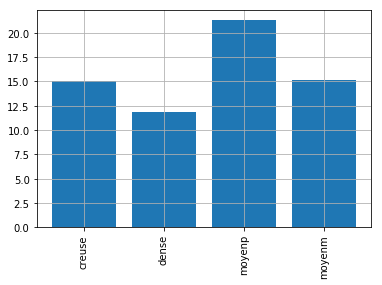

<Figure size 432x288 with 0 Axes>

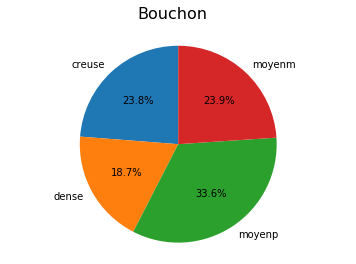

In [70]:
fig_bouchon_comp, ax1 = plt.subplots()
#pour avoir le nombre d'heure
values_b = [x/3600 for x in values_b]
#pour avoir par chauffeur
values_b = [x/26 for x in values_b]
x = range(0, 4)
ax1.bar(x,values_b)
plt.xticks(x, saisons, rotation='vertical')
#fig_bouchon_comp.suptitle('Heure de congestion par camion par saisons', fontsize=16)
plt.grid(True)
plt.show()
plt.savefig('plot_saison.png')

fig_tournee_comp, ax = plt.subplots()
ax.pie(values_b, labels=saisons,autopct='%1.1f%%',startangle=90)
ax.axis('equal') 
fig_tournee_comp.suptitle('Bouchon', fontsize=16)
plt.show()

Maintenant il s'agit de voir si ce que j'appel bouchon s'applique sur les chaufeurs de la même facon que ce que j'ai put constater sur TomTom : https://www.tomtom.com/en_gb/traffic-index/ranking/?country=CH

Ce qui vas très bien avec ce graphique c'est qu'il confirme que les chauffeurs ce debrouille globalement mieux que les suisses moyens. Et sont tout de même confronter à des congestions sur la route à hauteur de 20% en moyenne.

La tranche 5-6 heures s'explique par de mauvaise manipulation avant les tournées.

In [71]:
with open('db_ameliorer.csv', 'r') as db_up:
        df = pd.read_csv(db_up)

journee = [0] * 24
bouchon = [0] * 24

filtered = df[is_less_than_thresh(df['osrm_time'],df['diff_time'])]
filtered = filtered[filtered['diff_time'] > min_thresh]
filtered = filtered[filtered.osrm_time != 0]

for i, row in filtered.iterrows():
    start_time = iso_to_sec(row['pas_heurefin'])
    diff_time = row['diff_time']
    norm_time = row['osrm_time']
    
    index = []
    diff_time_by_index = []
    tmp = diff_time
    i = start_time // une_heure
    start = start_time
    while tmp > 0:
        index.append(i)
        next_palier = (i+1)*une_heure 
        diff = next_palier - start
        if diff > tmp:
            diff_time_by_index.append(tmp)
            tmp = 0
        else:
            diff_time_by_index.append(diff)
            tmp -= diff  
            i += 1
    for i, ind in enumerate(index):
        bouchon[ind] += diff_time_by_index[i]
    
for i, row in df.iterrows():
    start_time = iso_to_sec(row['pas_heurefin'])
    diff_time = row['diff_time']
    norm_time = row['osrm_time']
    
    index = []
    normal_time_by_index = []
    tmp = norm_time
    i = start_time // une_heure
    start = start_time
    while tmp > 0:
        index.append(i)
        next_palier = (i+1)*une_heure
        diff = next_palier - start
        if diff > tmp:
            normal_time_by_index.append(tmp)
            tmp = 0
        else:
            normal_time_by_index.append(diff)
            tmp -= diff
            i += 1
    
    for i, ind in enumerate(index):
        journee[ind] += normal_time_by_index[i]

journee = [1 if x == 0 else x for x in journee]
percentage = [x*100/y for x, y in zip(bouchon, journee)]
x = range(0, 24)
labels = ['0-1','1-2','2-3','3-4','4-5','5-6',
          '6-7','7-8','8-9','9-10','10-11',
          '11-12','12-13','13-14','14-15',
          '15-16','16-17','17-18','18-19',
          '19-20','20-21','21-22','22-23','23-24']

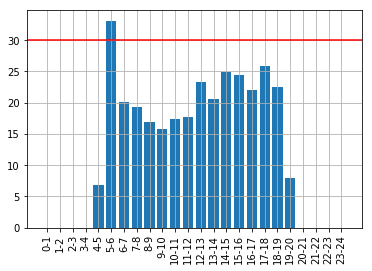

<Figure size 432x288 with 0 Axes>

In [72]:
fig, ax = plt.subplots()
#values_t = [x for x in values_t]

#fig.suptitle('Niveau de congestion pendant la journée', fontsize=16)
ax.axhline(30, color='red', alpha=1)
plt.bar(x, percentage)
plt.xticks(x, labels, rotation='vertical')
plt.grid(True)
plt.show()
plt.savefig('plot_congestion_day.png')

#la ligne rouge c'est la valeur moyenne pour les 6 plus grandes agglomération suisse. Lausanne Bern Zurich Geneve Lugano Bale

Ici je regarde les min et max pour chaque collone que j'ai crée pour voir si il y a des chose abérante ou non et aller explorer par la suite.

Au niveau d'OSRM rien d'étonnant. En revanche pour db et diff les valeurs max sont très élever ! Cela s'explique par la présente dans les tournée de point commencant et finissant à minuit puis le point suivant vers 13h.

Le minimum s'explique simplement par le présence de 0 automatique pour le dernier point de la tournée.

Par la suite je regarde le pourcentage total sur tout en cumulé et on obtiens environs 20% de congestion contre les 30% en suisse en général.

In [73]:
osrm = df['osrm_time']

max_osrm = osrm.max()
min_osrm = osrm.min()
df['osrm_time'].clip(lower=1,inplace=True)

print("le max osrm c'est : ", sec_to_iso(int(max_osrm)))
print("le min osrm c'est : ", sec_to_iso(int(min_osrm)))

db = df['db_time']

max_db = db.max()
min_db = db.min()

print("le max db c'est : ", sec_to_iso(int(max_db)))
print("le min db c'est : ", sec_to_iso(int(min_db)))

diff = df['diff_time']

max_diff = diff.max()
min_diff = diff.min()

print("le max diff c'est : ", sec_to_iso(int(max_diff)))
print("le min diff c'est : ", sec_to_iso(int(min_diff)))

filtered_diff = df[is_less_than_thresh(df['osrm_time'],df['diff_time'])]
filtered_diff = filtered_diff[filtered_diff['diff_time'] > min_thresh]
diff_sum = filtered_diff['diff_time'].sum()

le max osrm c'est :  3:00:36
le min osrm c'est :  0:00:00
le max db c'est :  13:24:00
le min db c'est :  0:00:00
le max diff c'est :  13:11:00
le min diff c'est :  0:00:00


In [74]:
osrm = df[df.osrm_time != 0]
osrm = osrm['osrm_time']
osrm_sum = osrm.sum()

print(sec_to_iso(diff_sum))
print(sec_to_iso(osrm_sum))
percentage = diff_sum * 100 / osrm_sum
print(percentage)

68 days, 16:05:02.400000
354 days, 13:16:19.400000
19.368096227737773


Ici je cherche a avoir tout les trajets existant dans la DB et de voir si j'attend une quantité d'apparation suffisante pour étudier les trajets plus en détails ou non. Malheuresement dans l'état actul il y a trop peu de redondance dans les trajets pour pouvoir utiliser cela. Ce qui mène a d'autre réfléction présenté plus tard.

In [75]:
trajets = dict()

for camion in camions:
    tournees_camion = df[df.pas_id_tour == camion]
    dates = tournees_camion.pas_date_passage.unique()
    for date in dates:
        tmp_df = tournees_camion[tournees_camion.pas_date_passage == date]
        for i, row in tmp_df.iterrows():
            for j, row2 in tmp_df.iterrows():
                if(j == i+1):
                    trajet = (row['pas_id_mariage'],row2['pas_id_mariage'])
                    if trajet in trajets and is_less_than_thresh(row['osrm_time'],row['diff_time']):
                        trajets[trajet] += 1
                    else:
                        trajets[trajet] = 1

In [76]:
print(max(trajets, key=lambda key: trajets[key]))
best_key = max(trajets, key=lambda key: trajets[key])
print(trajets[best_key])

(302687, 11742)
24


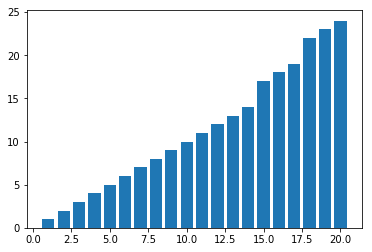

[42182, 2989, 682, 218, 99, 61, 30, 19, 13, 11, 8, 4, 2, 1, 1, 1, 1, 2, 4, 1]


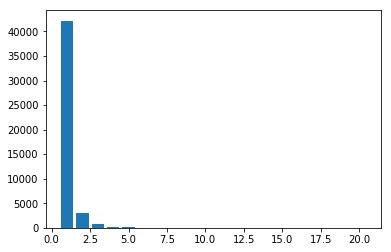

<Figure size 432x288 with 0 Axes>

In [77]:
"""
    le premier plot permet de voir les differente valeurs d'occurence présente dans la DB de base donc sans clustering
    le deuxieme plot montre leur tôt d'apparition dans la DB.
"""
values = list(set(trajets.values()))
plt.bar(range(1,len(values)+1),values)
plt.savefig('bar.png')
plt.show()

occurence = dict()
for trajet in trajets.keys():
    if trajets[trajet] in occurence :
        occurence[trajets[trajet]] += 1
    else :
        occurence[trajets[trajet]] = 1

occ = list(dict(collections.OrderedDict(sorted(occurence.items()))).values())
print(occ)
plt.bar(range(1,len(occ)+1),occ)
plt.show()
plt.savefig('plot_.png')

In [78]:
"""
    ici je regarde si j'ai eux des trajets qui sont apparu plus de 30 fois 
    ou non dans la DB si oui je les gardes car ils sont exploitable si non je ne fais rien
"""

limite_min = 30
computable_couple = []
list_val_per_couple = dict()
for couple, nb in trajets.items():
    if nb >= limite_min:
        computable_couple.append(couple)
        list_val_per_couple[couple] = []

for camion in camions:
    tournees_camion = df[df.pas_id_tour == camion]
    dates = tournees_camion.pas_date_passage.unique()
    for date in dates:
        tmp_df = tournees_camion[tournees_camion.pas_date_passage == date]
        for i, row in tmp_df.iterrows():
            for j, row2 in tmp_df.iterrows():
                if(j == i+1):
                    trajet = (row['pas_id_mariage'],row2['pas_id_mariage'])
                    if trajet in computable_couple and is_less_than_thresh(row['osrm_time'],row['diff_time']):
                        list_val_per_couple[trajet].append(row['diff_time'])

In [79]:
def mean_absolute_difference(l):
    """ compute the mean absolute difference of the given list """
    m = statistics.mean(l)
    new_l = [abs(x-m) for x in l]
    return statistics.mean(new_l)

In [80]:
mad = []
means = []
for couple in computable_couple:
    mad.append(mean_absolute_difference(list_val_per_couple[couple]))
    means.append(statistics.mean(list_val_per_couple[couple]))
print(len(mad))
print(len(means))

0
0


Le résultat est simple il n'y a pas de trajet exploitable dans la DB de base. Je ne vais donc rien pouvoir plot.
En revanche cela me pousse a explorer le principe de clustering. Il est possible que en faisant du clustering je m'appercoive que certains long trajet revienne en fait plus souvent que ce qu'on peu penser au premier abord.

In [81]:
for i, val in enumerate(means):
    print("%.3f" %val, end='        ')
    print("%.3f" %mad[i]) 
    print(sec_to_iso(val), end='     ')
    print(sec_to_iso(mad[i]))
    print()

In [82]:
if not not computable_couple:
    labels = [str(x) for x in computable_couple]
    tmp_df = pd.DataFrame({'means': means,
                           'mean_abs_diff': mad,
                           'labels': labels})

    ax = tmp_df.plot.bar(rot=0)

In [83]:
"""
    ici je veux voir le nombre de fois qu'un differentiel de plus de 1 heure est prit en compte comme bouchon ou non.
    cela peut m'indiquer également le nombre de fois qu'un repas potentiel à été prit en compte comme bouchon ou non.
"""
camions = df.pas_id_tour.unique()
nb_dej_comptabiliser = 0
nb_dej_total_possible = 0
for i, row in df.iterrows():
    if row['diff_time'] > une_heure:
        if is_less_than_thresh(row['osrm_time'],row['diff_time']):
            nb_dej_comptabiliser += 1
        nb_dej_total_possible += 1

print("le nombre de difference superieur à 1h et le nombre de difference superieur à 1 heure qui on été prise en compte dans le calcul des bouchons")
print(nb_dej_total_possible)
print(nb_dej_comptabiliser)

le nombre de difference superieur à 1h et le nombre de difference superieur à 1 heure qui on été prise en compte dans le calcul des bouchons
2485
57


In [84]:
geojson = {
    "type": "FeatureCollection",
    "features": []
}
already_added = set()
for i, row in df.iterrows():
    if row['pas_id_mariage'] not in already_added:
        already_added.add(row['pas_id_mariage'])
        feature = {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Point",
                "coordinates": [
                  row['alongitude'],
                  row['alatitude']
                ]
            }
        }
        geojson['features'].append(feature)

print(len(geojson['features']))

6248


In [85]:
"""
    je sauvegarde les points qui existe pour pouvoir les afficher sur une 
    carte pour avoir une idée de la représentation géographique de tout cela.
"""
with open('map_creation.geojson', 'w') as map_create:
    json.dump(geojson, map_create)
    map_create.close()

http://umap.openstreetmap.fr/en/map/anonymous-edit/336877:ba5zMp8eKoprBC8FaK94w2-HwUw

ici je veux aggregate les points entre eux qui appartienne au même zone globalement.

je vais faire des cluster réunissant tout les points à une distance de 500m les uns des autres.

In [86]:
aggregate_df = df[['pas_id_mariage','alongitude','alatitude']]
aggregate_df= aggregate_df.drop_duplicates()

In [87]:
""" 
    ce passage prend pas mal de temps !!!!!!
    il s'agit ici de parcourir la DB et de systematiquement ajouter a un nouveau 
    set l'ensemble des points qui sont a 500m ou moins
"""
list_of_sets = []
for i, row1 in aggregate_df.iterrows():
    new_set = set()
    for j, row2 in aggregate_df.iterrows():
        if dist_haversin(row1.alongitude,row1.alatitude,row2.alongitude,row2.alatitude) < 500:
            new_set.add(row2.pas_id_mariage)
    list_of_sets.append(new_set)

In [88]:
list_of_lists = [list(x) for x in list_of_sets]
with open('point_aggregation.json', 'w') as check_save:
    json.dump(list_of_lists, check_save)
check_save.close()

In [89]:
finish = False
while not finish:
    supersets = [list_of_sets[0]]
    finish = True
    for s in list_of_sets[1:]:
        in_super_set = False
        for ss in supersets:
            if not s.isdisjoint(ss):
                ss |= s
                finish = False
                in_super_set = True
                break
        if not in_super_set:
            supersets.append(s)
    list_of_sets = supersets

In [90]:
list_of_lists = [list(x) for x in list_of_sets]
with open('point_aggregation.json', 'w') as check_save:
    json.dump(list_of_lists, check_save) 

In [91]:
"""
    Maintenant que j'ai tout mes cluster ... j'ai envie de pouvoir 
    les visualiser sur une carte donc je setup simplement la moyenne 
    de la position des points présent dans les cluster
"""
average_points = pd.DataFrame(columns=['pas_id_mariage','alongitude','alatitude'])
j = 1 
for s in list_of_sets:
    sum_of_lon = 0
    sum_of_lat = 0
    for i, row in aggregate_df.iterrows():
        if row['pas_id_mariage'] in s:
            sum_of_lon += float(row.alongitude)
            sum_of_lat += float(row.alatitude)
    avg_lon = sum_of_lon / len(s)
    avg_lat = sum_of_lat / len(s)
    tmp_df = pd.DataFrame([[j, avg_lon, avg_lat]],columns=['pas_id_mariage','alongitude','alatitude'])
    j += 1
    average_points = average_points.append(tmp_df,ignore_index=True)

In [92]:
average_points_csv = average_points.to_csv()

if not os.path.isfile('average_points.csv'):
    with open('average_points.csv', 'w') as avg_pt:
        avg_pt.write(average_points_csv)
        avg_pt.close()

In [93]:
"""
    ici je regarde la mean absolute difference entre chaque cluster. Donc pour cela je compte 
    d'abord le nombre de trajet entre chaque cluster et après je fais mon calcul et mon plot de graph
"""
trajets_by_couple = dict()

for camion in camions:
    tournees_camion = df[df.pas_id_tour == camion]
    dates = tournees_camion.pas_date_passage.unique()
    for date in dates:
        tmp_df = tournees_camion[tournees_camion.pas_date_passage == date]
        for i, row in tmp_df.iterrows():
            for j, row2 in tmp_df.iterrows():
                if(j == i+1):
                    for ind, s in enumerate(list_of_sets):
                        if row.pas_id_mariage in s :
                            fpi = ind
                        if row2.pas_id_mariage in s :
                            spi = ind
                    if fpi != spi and is_less_than_thresh(row['osrm_time'],row['diff_time']):
                        if (fpi,spi) not in trajets_by_couple :
                            trajets_by_couple[(fpi,spi)] = []
                        trajets_by_couple[(fpi,spi)].append(row.diff_time)

In [94]:
mads = []
means = []
couples = []
for couple in trajets_by_couple.keys():
    if len(trajets_by_couple[couple]) > 30:
        print()
        couples.append(couple)
        mads.append(mean_absolute_difference(trajets_by_couple[couple]))
        means.append(statistics.mean(trajets_by_couple[couple]))
print(len(mads))
print(len(means))
#print(trajets_by_couple)


1
1


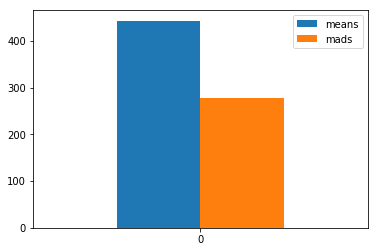

In [95]:
labels = [str(x) for x in couples]
tmp_df = pd.DataFrame({'means': means,
                       'mads': mads,
                       'labels': labels})

ax = tmp_df.plot.bar(rot=0)

In [96]:
geojson = {
    "type": "FeatureCollection",
    "features": []
}
already_added = set()
for i, row in average_points.iterrows():
    if row['pas_id_mariage'] not in already_added:
        already_added.add(row['pas_id_mariage'])
        feature = {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Point",
                "coordinates": [
                  row['alongitude'],
                  row['alatitude']
                ]
            }
        }
        geojson['features'].append(feature)

print(len(geojson['features']))

with open('map_creation_aggreg.geojson', 'w') as map_create_agg:
    json.dump(geojson, map_create_agg)
    map_create_agg.close()

1981


http://umap.openstreetmap.fr/en/map/anonymous-edit/336914:wLPXGqADAVuQGAP5IDRXuzvI6TQ

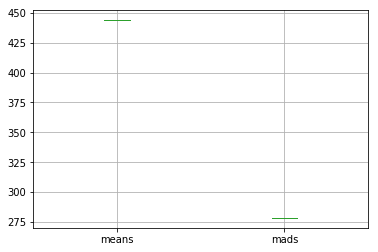

In [97]:
"""
    ici je fait juste un box plot pour voir un peut la distribution de chaque valeur means et mads.
"""
tmp_df.boxplot(column=['means','mads'])

pas_id_mariage       1315
alongitude        6.13851
alatitude         46.2023
Name: 1314, dtype: object
pas_id_mariage       1322
alongitude        6.09912
alatitude         46.2231
Name: 1321, dtype: object


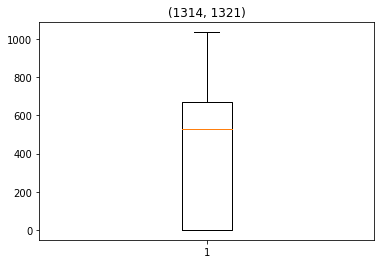

In [98]:
for couple in trajets_by_couple.keys():
    if len(trajets_by_couple[couple]) > 30:
        for i, row in average_points.iterrows():
            if i in couple:
                print(row)
        fig1, ax1 = plt.subplots()
        ax1.set_title(couple)
        ax1.boxplot(trajets_by_couple[couple])

A ce moment la je voulais regarder ce qui ce passer dans mon tableau Niveau de congestion durant la journée pour essaye de voir ce qu'il ce passe entre 5h et 6h. Pour cela j'ai juste afficher les trajet qui commence entre 5 et 6h et le point d'après et on remarque des comportement interessant.

In [99]:
def in_interval(time_string):
    return iso_to_sec('06:00:00') > iso_to_sec(time_string) and iso_to_sec(time_string) > iso_to_sec('05:00:00')

In [100]:
filtered = df[is_less_than_thresh(df['osrm_time'],df['diff_time'])]
filtered = filtered[filtered['diff_time'] > min_thresh]
filtered = filtered[filtered.osrm_time != 0]
second_line = False
for i, row in filtered.iterrows():
    if second_line:
        print("2 eme ligne :")
        print(row)
        second_line = False
    if in_interval(row['pas_heurefin']):
        if not second_line:
            print("1ere ligne :")
            print(row)
        second_line = True
    

1ere ligne :
Unnamed: 0                   0
pas_id                 1623519
pas_date_passage    2018-03-28
pas_id_mariage           50265
pas_id_tour               1301
pas_heuredebut        05:49:00
pas_heurefin          05:49:00
alatitude              46.3628
alongitude             8.97133
osrm_time                 1632
db_time                   3960
diff_time                 2328
Name: 864, dtype: object
2 eme ligne :
Unnamed: 0                   4
pas_id                 1623523
pas_date_passage    2018-03-28
pas_id_mariage           49862
pas_id_tour               1301
pas_heuredebut        08:13:00
pas_heurefin          08:22:00
alatitude              46.2758
alongitude             9.01005
osrm_time               1052.9
db_time                   2220
diff_time               1167.1
Name: 868, dtype: object
1ere ligne :
Unnamed: 0                   0
pas_id                 1653594
pas_date_passage    2018-07-11
pas_id_mariage         1008570
pas_id_tour                 12
pas_heurede

1ere ligne :
Unnamed: 0                   0
pas_id                 1635386
pas_date_passage    2018-05-09
pas_id_mariage         1011173
pas_id_tour                 13
pas_heuredebut        05:37:00
pas_heurefin          05:54:01
alatitude              47.3682
alongitude               8.782
osrm_time                726.6
db_time                   1739
diff_time               1012.4
Name: 74644, dtype: object
2 eme ligne :
Unnamed: 0                   9
pas_id                 1635404
pas_date_passage    2018-05-09
pas_id_mariage          109295
pas_id_tour                 13
pas_heuredebut        10:45:00
pas_heurefin          11:00:00
alatitude              47.2589
alongitude             8.98897
osrm_time               2130.2
db_time                   3060
diff_time                929.8
Name: 74653, dtype: object
1ere ligne :
Unnamed: 0                   0
pas_id                 1637955
pas_date_passage    2018-05-18
pas_id_mariage         1009645
pas_id_tour                 13
pas_heu

In [101]:
print(len(trajets.keys()))
print(len(trajets_by_couple.keys()))

46329
12888


In [102]:
"""
    J'ai regarder a l'exterieur des cluster que j'ai former. Mais que ce passe t'il a l'interieur ? 
    Y a t'il des cluster qui pourrais être pénaliser grandement et dans leur entiérté car trop embouteillé.
"""
trajets_in_agg = dict()
for camion in camions:
    tournees_camion = df[df.pas_id_tour == camion]
    dates = tournees_camion.pas_date_passage.unique()
    for date in dates:
        tmp_df = tournees_camion[tournees_camion.pas_date_passage == date]
        for i, row in tmp_df.iterrows():
            for j, row2 in tmp_df.iterrows():
                if(j == i+1):
                    for ind, s in enumerate(list_of_sets):
                        if row.pas_id_mariage in s :
                            fpi = ind
                        if row2.pas_id_mariage in s :
                            spi = ind
                    if fpi == spi and is_less_than_thresh(row['osrm_time'],row['diff_time']):
                        #print(fpi)
                        if str(fpi+1) not in trajets_in_agg.keys() :  
                            traj = {
                                "location" : (average_points['alongitude'][fpi + 1], average_points['alatitude'][fpi + 1]),
                                "list_traj" : []
                            }
                            trajets_in_agg[str(fpi+1)] = dict()
                            trajets_in_agg[str(fpi+1)] = traj.copy()
                        trajets_in_agg[str(fpi+1)]['list_traj'].append(row.diff_time)

In [103]:
mads = []
means = []
agg = []
for couple in trajets_in_agg.keys():
    if len(trajets_in_agg[couple]['list_traj']) > 30:
        print(trajets_in_agg[couple]['location'])
        agg.append(couple)
        mads.append(mean_absolute_difference(trajets_in_agg[couple]['list_traj']))
        means.append(statistics.mean(trajets_in_agg[couple]['list_traj']))
print(len(mads))
print(len(means))

geojson = {
    "type": "FeatureCollection",
    "features": []
}
already_added = set()
for couple in trajets_in_agg.keys():
    if len(trajets_in_agg[couple]['list_traj']) > 30:
        if couple not in already_added:
            already_added.add(couple)
            feature = {
                "type": "Feature",
                "properties": {},
                "geometry": {
                    "type": "Point",
                    "coordinates": [
                      trajets_in_agg[couple]['location'][0],
                      trajets_in_agg[couple]['location'][1]
                    ]
                }
            }
            geojson['features'].append(feature)
print(len(geojson['features']))

with open('map_relevent_cluster.geojson', 'w') as map_create_agg:
    json.dump(geojson, map_create_agg)
    map_create_agg.close()

(8.9325551, 46.0021883)
(8.620141002230222, 47.39803688447381)
(8.554425648930085, 47.478750862974394)
(8.788057123393118, 47.53556563122444)
(8.939635800000003, 47.5464761)
(8.617331153783358, 47.68188132339522)
(9.395547950000001, 47.4586901)
(9.419053476479514, 47.43553441738224)
(8.300104699999999, 47.041059450000006)
(7.701819, 47.402397)
(8.559050099999999, 47.4203074)
(9.5599805, 47.377174)
(9.549232909104674, 47.422539296249255)
(9.025555270177406, 47.49553164311956)
(7.949248821619866, 47.281907708072325)
(7.556006177023207, 47.203876103615364)
(7.230108199999999, 47.11298220000001)
(7.405201982399293, 46.9424957043395)
(7.577022987158978, 47.227473994536425)
(7.863909333333335, 46.68110680000001)
(6.129022, 46.180571)
(6.233055799999999, 46.24682825)
(5.995724, 46.193302)
(6.57919930000003, 46.5509483)
(7.13276461015185, 46.79333870495003)
25
25
25


<Figure size 432x288 with 0 Axes>

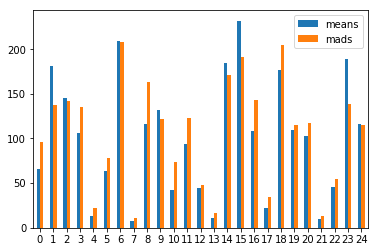

In [105]:
labels = [str(x) for x in agg]
tmp_df = pd.DataFrame({'means': means,
                       'mads': mads,
                       'labels': labels})
fig = plt.figure()
ax = tmp_df.plot.bar(rot=0)
#ax.savefig('plot_means_mads_in_500.png')

après avoir fait les cluster avec 500m je tente de faire les cluster avec 1km peut être aurais-je plus de résultat. 
Il n'y a pas d'interet a faire beaucoup plus car au delas on ce retrouverais avec des clusters qui regroupe beaucoup trop de point.

In [106]:
#je regarde avec 1 km parceque pourquoi pas après tout
aggregate_df = df[['pas_id_mariage','alongitude','alatitude']]
aggregate_df= aggregate_df.drop_duplicates()

list_of_sets = []
for i, row1 in aggregate_df.iterrows():
    new_set = set()
    for j, row2 in aggregate_df.iterrows():
        if dist_haversin(row1.alongitude,row1.alatitude,row2.alongitude,row2.alatitude) < 1000:
            new_set.add(row2.pas_id_mariage)
    list_of_sets.append(new_set)

list_of_lists = [list(x) for x in list_of_sets]
with open('point_aggregation_km.json', 'w') as check_save:
    #list_of_sets_json = json.dumps(list_of_lists)
    json.dump(list_of_lists, check_save)
check_save.close()

finish = False
while not finish:
    supersets = [list_of_sets[0]]
    finish = True
    for s in list_of_sets[1:]:
        in_super_set = False
        for ss in supersets:
            if not s.isdisjoint(ss):
                ss |= s
                finish = False
                in_super_set = True
                break
        if not in_super_set:
            supersets.append(s)
    list_of_sets = supersets

list_of_lists = [list(x) for x in list_of_sets]
with open('point_aggregation_km.json', 'w') as check_save:
    json.dump(list_of_lists, check_save)

In [107]:
average_points = pd.DataFrame(columns=['pas_id_mariage','alongitude','alatitude'])
j = 1 
for s in list_of_sets:
    sum_of_lon = 0
    sum_of_lat = 0
    for i, row in aggregate_df.iterrows():
        if row['pas_id_mariage'] in s:
            sum_of_lon += float(row.alongitude)
            sum_of_lat += float(row.alatitude)
    avg_lon = sum_of_lon / len(s)
    avg_lat = sum_of_lat / len(s)
    tmp_df = pd.DataFrame([[j, avg_lon, avg_lat]],columns=['pas_id_mariage','alongitude','alatitude'])
    j += 1
    average_points = average_points.append(tmp_df,ignore_index=True)

In [108]:
average_points_csv = average_points.to_csv()

if not os.path.isfile('average_points_1km.csv'):
    with open('average_points_1km.csv', 'w') as avg_pt:
        avg_pt.write(average_points_csv)
        avg_pt.close()

In [109]:
trajets_by_couple = dict()

for camion in camions:
    tournees_camion = df[df.pas_id_tour == camion]
    dates = tournees_camion.pas_date_passage.unique()
    for date in dates:
        tmp_df = tournees_camion[tournees_camion.pas_date_passage == date]
        for i, row in tmp_df.iterrows():
            for j, row2 in tmp_df.iterrows():
                if(j == i+1):
                    for ind, s in enumerate(list_of_sets):
                        if row.pas_id_mariage in s :
                            fpi = ind
                        if row2.pas_id_mariage in s :
                            spi = ind
                    if fpi != spi and is_less_than_thresh(row['osrm_time'],row['diff_time']):
                        if (fpi,spi) not in trajets_by_couple :
                            trajets_by_couple[(fpi,spi)] = []
                        trajets_by_couple[(fpi,spi)].append(row.diff_time)

In [110]:
mads = []
means = []
couples = []
for couple in trajets_by_couple.keys():
    if len(trajets_by_couple[couple]) > 30:
        print()
        couples.append(couple)
        mads.append(mean_absolute_difference(trajets_by_couple[couple]))
        means.append(statistics.mean(trajets_by_couple[couple]))
print(len(mads))
print(len(means))








7
7


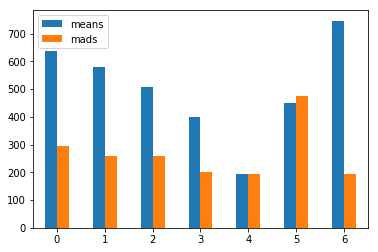

In [111]:
labels = [str(x) for x in couples]
tmp_df = pd.DataFrame({'means': means,
                       'mads': mads,
                       'labels': labels})

ax = tmp_df.plot.bar(rot=0)

In [112]:
trajets_in_agg = dict()
for camion in camions:
    tournees_camion = df[df.pas_id_tour == camion]
    dates = tournees_camion.pas_date_passage.unique()
    for date in dates:
        tmp_df = tournees_camion[tournees_camion.pas_date_passage == date]
        for i, row in tmp_df.iterrows():
            for j, row2 in tmp_df.iterrows():
                if(j == i+1):
                    for ind, s in enumerate(list_of_sets):
                        if row.pas_id_mariage in s :
                            fpi = ind
                        if row2.pas_id_mariage in s :
                            spi = ind
                    if fpi == spi and is_less_than_thresh(row['osrm_time'],row['diff_time']):
                        #print(fpi)
                        if str(fpi+1) not in trajets_in_agg.keys() :  
                            traj = {
                                "location" : (average_points['alongitude'][fpi + 1], average_points['alatitude'][fpi + 1]),
                                "list_traj" : []
                            }
                            trajets_in_agg[str(fpi+1)] = dict()
                            trajets_in_agg[str(fpi+1)] = traj.copy()
                        trajets_in_agg[str(fpi+1)]['list_traj'].append(row.diff_time)

3
3
3
8
8
8
8
8
16
10
39
41
8
8
8
0
0
8
8
8
22
12
10
8
40
3
8
8
8
8
8
8
8
14
0
8
8
3
3
3
3
8
8
8
0
8
8
8
8
21
8
8
10
8
8
8
3
15
8
9
0
0
8
8
8
8
8
8
3
8
8
12
0
0
57
17
1
0
8
8
39
3
8
8
8
8
8
8
8
8
8
8
8
8
8
10
8
8
3
3
8
8
8
8
8
15
39
40
17
0
8
8
8
8
8
8
35
8
8
3
3
8
8
8
8
8
8
8
8
8
8
8
12
10
10
8
8
8
3
8
8
8
8
8
10
10
10
0
0
0
8
8
8
8
8
8
8
8
8
10
10
8
8
8
8
8
8
8
8
8
8
0
8
8
8
8
15
8
8
8
8
10
8
8
8
8
3
8
0
22
8
8
8
8
8
10
8
1
3
3
8
8
8
8
0
8
8
8
22
22
8
8
3
8
8
8
16
1
8
8
8
8
8
0
8
8
8
8
8
5
3
8
8
8
8
12
8
3
3
8
8
8
8
8
8
12
8
8
3
3
8
8
3
8
8
8
8
8
8
15
8
8
3
8
15
0
8
3
3
8
8
0
8
8
8
8
8
3
8
15
9
8
1
8
8
8
3
3
61
61
61
61
61
61
61
61
61
69
69
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
64
61
61
61
61
61
61
62
62
61
61
61
61
61
61
61
69
64
76
61
61
62
61
61
61
61
61
61
61
61
61
61
61
61
61
69
76
61
61
61
61
61
61
61
62
62
61
61
61
61
61
61
64
64
61
61
61
61
78
61
61
61
61
62
62
61
61
61
61
61
64
62
61
61
69
69
69
64
61
61
61
61
61
61
61
62
61
61
61
61
64
64
61
61
61
61
61
61
82
6

61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
265
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
452
98
419
422
422
422
452
419
419
176
139
165
419
419
422
422
426
450
154
201
450
419
178
201
98
419
452
419
172
154
419
426
154
201
161
178
98
419
419
419
419
419
422
452
419
419
419
419
422
452
452
201
419
422
179
201
201
139
98
422
422
452
419
201
450
419
419
98
422
422
452
422
450
161
178
426
422
422
419
98
139
422
422
172
165
419
201
419
201
98
419
426
201
419
419
426
452
419
419
422
422
450
419
419
98
98
452
452
419
201
461
426
98
419
426
154
98
201
426
422
161
201
422
154
154
154
201
488
186
419
419
422
435
435
443
443
483
430
500
185
185
483
488
478
185
434
434
434
490
483
195
195
195
481
482
493
478
478
483
483
483
195
434
185
435
430
482
488
434
434
483
483
195


787
666
797
763
763
781
781
781
781
780
763
763
763
763
767
93
666
800
800
763
763
763
666
666
666
666
763
763
763
93
760
797
763
763
93
93
666
760
760
666
763
763
765
93
93
780
666
763
763
763
763
763
774
666
666
763
763
666
93
93
666
93
93
93
93
93
93
767
763
763
763
765
771
93
780
763
763
763
93
93
93
93
93
93
93
93
93
794
763
763
763
763
666
93
93
93
93
763
93
93
93
93
93
93
93
93
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
837
845
837
837
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
837
834
834
837
837
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
837
837
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834
834


859
859
859
859
859
859
859
859
859
859
859
859
912
859
859
859
859
859
859
859
859
859
859
859
925
912
859
859
859
859
859
859
859
859
859
859
859
859
859
859
912
912
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
925
925
859
859
859
912
859
859
859
859
859
912
912
859
859
859
859
859
859
859
859
859
925
859
859
925
859
859
859
859
859
912
859
859
859
859
859
859
859
859
925
859
859
859
859
859
859
912
859
859
859
859
925
859
859
859
859
859
859
859
859
859
912
859
915
912
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
912
912
859
859
859
859
908
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
925
925
859
859
859
859
912
912
859
859
859
859
859
859
859
859
859
859
859
859
859
859
859
912
912
859
859
859
859
859
859
859
859
859
859
924
859
912
859
859
859
859
859
859
859
859
859
859
859
918
859
859
859
859
859


93
93
93
93
93
93
93
93
93
93
93
93
93
93
93
93
93
93
93
93
93
669
669
93
675
669
680
93
93
93
93
93
93
93
93
93
695
669
669
669
669
93
93
93
683
700
93
93
93
93
93
93
669
669
669
93
675
93
93
93
93
93
93
93
93
682
93
93
93
93
93
93
669
669
669
93
93
675
93
683
93
93
93
669
669
669
669
669
669
675
93
93
93
93
93
93
93
93
93
93
669
669
669
675
93
93
93
93
680
669
669
794
683
93
93
93
669
669
669
669
669
669
93
93
93
685
93
93
93
93
93
93
93
669
675
93
93
93
93
1276
93
683
700
93
831
93
669
669
669
669
669
675
93
93
93
93
93
685
681
93
683
93
93
93
93
93
93
669
669
669
675
93
93
93
93
1276
794
669
669
669
669
669
669
669
93
93
93
683
683
93
93
93
93
669
669
675
669
93
93
93
1276
93
93
669
675
93
93
93
93
93
669
669
669
669
669
669
696
93
93
702
93
683
683
93
853
853
859
859
859
859
859
1276


In [113]:
mads = []
means = []
agg = []
for couple in trajets_in_agg.keys():
    if len(trajets_in_agg[couple]['list_traj']) > 30:
        print(trajets_in_agg[couple]['location'])
        agg.append(couple)
        mads.append(mean_absolute_difference(trajets_in_agg[couple]['list_traj']))
        means.append(statistics.mean(trajets_in_agg[couple]['list_traj']))
print(len(mads))
print(len(means))

geojson = {
    "type": "FeatureCollection",
    "features": []
}
already_added = set()
for couple in trajets_in_agg.keys():
    if len(trajets_in_agg[couple]['list_traj']) > 30:
        if couple not in already_added:
            already_added.add(couple)
            feature = {
                "type": "Feature",
                "properties": {},
                "geometry": {
                    "type": "Point",
                    "coordinates": [
                      trajets_in_agg[couple]['location'][0],
                      trajets_in_agg[couple]['location'][1]
                    ]
                }
            }
            geojson['features'].append(feature)
print(len(geojson['features']))

with open('map_relevent_cluster_1km.geojson', 'w') as map_create_agg:
    json.dump(geojson, map_create_agg)
    map_create_agg.close()

(8.847744500000003, 46.1731175)
(9.006956048812123, 46.17315438358764)
(8.670577600247396, 47.380189716097526)
(8.788057123393118, 47.53556563122444)
(8.939635800000003, 47.5464761)
(8.619069078152796, 47.682440636162674)
(9.395259795143605, 47.4606596465047)
(8.867298971760754, 47.57318654829234)
(9.361012, 47.480187)
(9.397706781241112, 47.50201557941698)
(8.821545000000002, 47.193215333333335)
(8.276082341348681, 47.070983247915805)
(8.3151416, 46.9895289)
(8.1771892, 47.2116495)
(7.6949822164059745, 47.39911354764461)
(9.636407391841772, 47.430442563615735)
(9.527264, 47.086338)
(9.549232909104674, 47.422539296249255)
(9.025555270177406, 47.49553164311956)
(9.15653474810262, 47.43313136315805)
(8.9658461, 46.0675998)
(7.991180458867795, 47.35772862280243)
(9.171722786458352, 47.321775508999146)
(7.396684786516971, 47.192636430149186)
(7.656496562424067, 47.238468797212334)
(7.226464374358475, 47.11528982965382)
(7.661688000000002, 46.8990323)
(7.7034061, 46.6733875)
(8.6486981, 47.

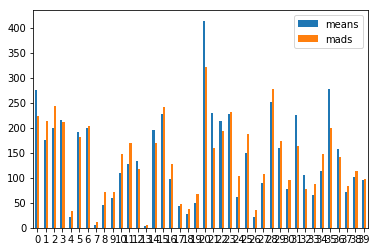

In [115]:
labels = [str(x) for x in agg]
tmp_df = pd.DataFrame({'means': means,
                       'mads': mads,
                       'labels': labels})

ax = tmp_df.plot.bar(rot=0)
#ax.savefig('plot_means_mads_in_1km.png')

In [116]:
traj = 0
for camion in camions:
    tournees_camion = df[df.pas_id_tour == camion]
    dates = tournees_camion.pas_date_passage.unique()
    for date in dates:
        tmp_df = tournees_camion[tournees_camion.pas_date_passage == date]
        traj += tmp_df.count()[0] - 1

print(traj)

79712


In [117]:
"""
    cette cellule me permet de generer le csv contenant les addresse pour les quelles 
    le géocodeur ne parviens pas a trouver de correspondance.
"""
df = pd.read_csv(file, sep=';')
df.drop_duplicates(subset=['pas_id_mariage'],inplace=True)
to_complete = pd.DataFrame(columns= df.columns)

for i, row in df[df.alongitude == 0].iterrows():
    address = '' + str(row['arue2']) + ', ' + str(row['apostal']) + ' ' + str(row['aville'])
    js = [{"ID": 1, "address": address}]
    r = re.post(server_url, headers=header, json=js)
    r_js = json.loads(r.text)
    #print(r_js)
    if r_js[0]['matching'] > 80:
        df.loc[i, 'alongitude'] = r_js[0]['coordinate']['longitude']
        df.loc[i, 'alatitude'] = r_js[0]['coordinate']['latitude']
    
for i, row in df.iterrows():
    #print(row['alongitude'])
    if float(row['alongitude']) <= 0:
        to_complete = to_complete.append(row,ignore_index=True)
to_complete_csv = to_complete.to_csv()




ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /geocode (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x11f5ba278>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [ ]:
with open('empty_row.csv', 'w') as to_complete_pt:
    to_complete_pt.write(to_complete_csv)
    to_complete_pt.close()